# PCA using Sentinel-2

Authors:

* Jeroen Wannijn

## Introduction

In this notebook we will be performing a principal component analysis using a full data cube of preprocessed Sentinel data (for the WEED-project) created retrieved from- and processed on openEO.

In [1]:
from pathlib import Path
import openeo
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import xarray as xr
import joblib
import requests
from eo_processing.openeo.processing import generate_master_feature_cube

# openeo version
openeo.client_version()

'0.40.0'

In [2]:
## creates a output directory if it doesn't exist.
base_path = Path("results")
if not base_path.is_dir():
    base_path.mkdir()

## Authentication

We first need to connect to an openEO provider. Most providers require you to register an account, and provide you with a basic amount of processing credits. 
In this notebook we will use the Copernicus Data Scpace Ecosystem as openEO provider.

All the known openEO providers and their services:
https://hub.openeo.org/ 

More info on authentication:
https://open-eo.github.io/openeo-python-client/auth.html

Run the `authenticate_oidc()` method again in case you can no longer connect. The token expires after a certain time.

In [3]:
backend_url = "openeo.dataspace.copernicus.eu/"

eoconn = openeo.connect(backend_url)
eoconn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Load collection

We start off by loading in a collection. In this case, we are loading in Sentinel-2 L2A. More information on the collections available can be displayed with `eoconn.list_collections()`.
Use `eoconn.describe_collection("SENTINEL2_L2A")` for example to get the description of a specific collection.

More information on finding and loading data: 
https://open-eo.github.io/openeo-python-client/data_access.html

In [4]:
BBOX = {"east": 4880000, "south": 2899000, "west": 4879000, "north": 2900000, 'crs': 'EPSG:3035'} # 4x4km bbox in Germany
DATE_START = "2021-01-01"
DATE_END = "2021-03-01"

### Select usable observations

For this exercise we use the bands and derivates of a master feature cube of the weed Project, which has 273 variables in total, ideal for the calculation of PCA bands.

In [5]:
sentinel_master_cube = generate_master_feature_cube(
        connection=eoconn,
        S1_collection='SENTINEL1_GRD',
        S2_collection='SENTINEL2_L2A',
        bbox=BBOX,
        start=DATE_START,
        end=DATE_END)


In [10]:
sentinel_master_cube.download(base_path / "sentinel_training_cube.nc")

In [10]:
from udf_dim_reduction import apply_datacube # This module MUST exist in your environment

ds = xr.open_dataset(base_path / "sentinel_training_cube.nc")

# Assume the relevant DataArray is called "cube"
band_vars = [var for var in ds.data_vars if ds[var].dtype.kind in 'fc' and set(ds[var].dims) == {'y', 'x'}]

print(f"Selected {len(band_vars)} bands")

# --- Step 2: Stack them into a 3D DataArray (bands, y, x) ---
# This creates a new "bands" dimension

cube = xr.concat([ds[var] for var in band_vars], dim="bands")
cube = cube.assign_coords(bands=band_vars)  # name the bands

# Download the pickle file
model_url = f"https://s3.waw3-1.cloudferro.com/swift/v1/ecdc-waw3-1-ekqouvq3otv8hmw0njzuvo0g4dy0ys8r985n7dggjis3erkpn5o/tests/JeroenW/PCA/test_sentinel_pca_model.pkl"
response = requests.get(model_url)
response.raise_for_status()

# Save the pickle to disk
with open(base_path / "pca.pkl", "wb") as f:
    f.write(response.content)

# Load with cloudpickle
with open(base_path / "pca.pkl", 'rb') as f:
    pca_reloaded = joblib.load(base_path /"pca.pkl")  # Make sure the source module is available

# Use the PCA model
context = {"n_components": 4, "model_url": model_url}
result = apply_datacube(cube, context)
print(result)


Selected 237 bands
https://s3.waw3-1.cloudferro.com/swift/v1/ecdc-waw3-1-ekqouvq3otv8hmw0njzuvo0g4dy0ys8r985n7dggjis3erkpn5o/tests/JeroenW/PCA/test_sentinel_pca_model.pkl


ValueError: Failed to load reduction model from https://s3.waw3-1.cloudferro.com/swift/v1/ecdc-waw3-1-ekqouvq3otv8hmw0njzuvo0g4dy0ys8r985n7dggjis3erkpn5o/tests/JeroenW/PCA/test_sentinel_pca_model.pkl: Downloaded file is not a valid PCA or t-SNE pickle file.

## Visualise RGB to get a view of the area
Load RGB data from Sentinel-2 collection

In [7]:
rgb_cube = eoconn.load_collection(
    "SENTINEL2_L2A",  # or your collection id
    spatial_extent=BBOX,
    temporal_extent="2021",
    bands=['B02', 'B03', 'B04']
)

# Reduce to a single time slice, e.g. take median over time to get 2D image
rgb_cube = rgb_cube.reduce_dimension(dimension='t', reducer='mean')

rgb_cube.download(base_path / "rgb_cube.tiff")

Visualize RGB data

Pixel Size: 10.0 x 10.0 units


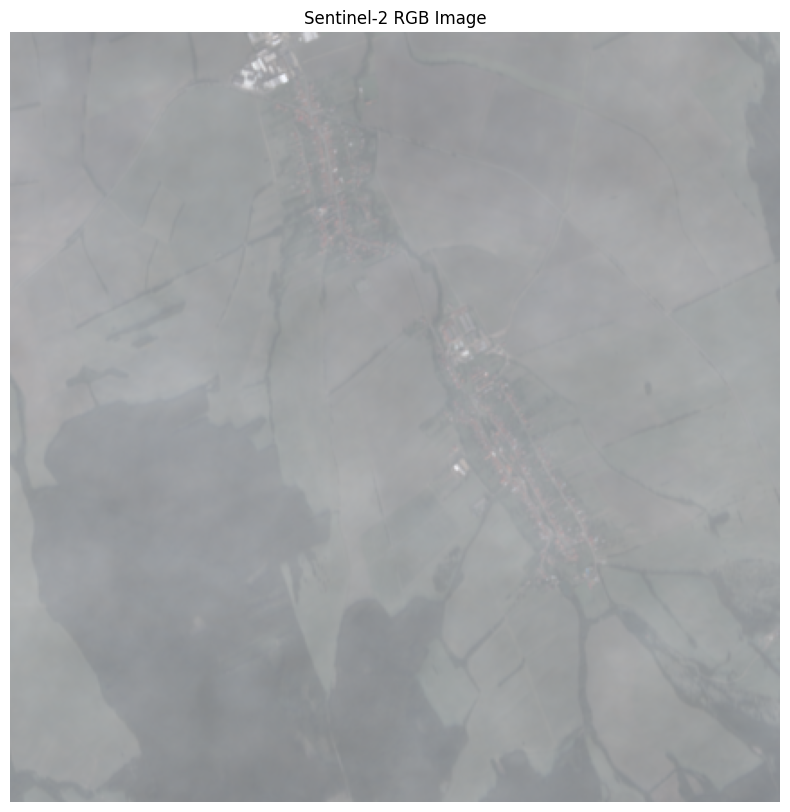

In [7]:
with rasterio.open(base_path / "rgb_cube.tiff") as src:
    # Print pixel size
    pixel_size_x = src.transform.a  # pixel width
    pixel_size_y = -src.transform.e  # pixel height (negative because of coordinate system)
    print(f"Pixel Size: {pixel_size_x} x {pixel_size_y} units")

    # Read the bands by their Sentinel-2 band numbers
    r = src.read(3)  # Band 4 - Red
    g = src.read(2)  # Band 3 - Green
    b = src.read(1)  # Band 2 - Blue

rgb = np.stack([r, g, b], axis=0)
rgb_img = np.transpose(rgb, (1, 2, 0))

# Normalize image for display (scale 0-1)
rgb_norm = rgb_img / np.max(rgb_img)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_norm)
plt.title("Sentinel-2 RGB Image")
plt.axis("off")
plt.show()

## Calculate PCA


In [8]:
job_options = {
    "driver-memory": "4G",
    "driver-memoryOverhead": "4G",
    "driver-cores": "1",
    "executor-memory": "2000m",
    "executor-memoryOverhead": "256m",
    "python-memory": "4G",
    "executor-cores": "1",
    "max-executors": "20",
    "logging-threshold": "info"
 }

In [ ]:
## Apply the segmentation UDF using `apply_neighborhood`
pca_udf_obj = openeo.UDF.from_file("udf_pca.py", runtime="Python", context={"n_components": 4})
PCA_components = sentinel_master_cube.apply(
    process=pca_udf_obj,
)
PCA_job = PCA_components.create_job(
    title="PCA_job", out_format="NetCDF", job_options=job_options
)
PCA_job.start_and_wait()

0:00:00 Job 'j-25061608155641639d42f3bcbfd2ce71': send 'start'
0:00:13 Job 'j-25061608155641639d42f3bcbfd2ce71': created (progress 0%)
0:00:18 Job 'j-25061608155641639d42f3bcbfd2ce71': running (progress N/A)


In [46]:
PCA_job.download_result("results/componentsPCA.nc")

WindowsPath('results/componentsPCA.nc')

In [47]:
# Load dataset
PCA_data = xr.open_dataset(base_path / "componentsPCA.nc")
print(PCA_data)

<xarray.Dataset> Size: 188kB
Dimensions:  (x: 108, y: 108)
Coordinates:
  * x        (x) float64 864B 6.926e+05 6.926e+05 ... 6.937e+05 6.937e+05
  * y        (y) float64 864B 5.426e+06 5.426e+06 ... 5.424e+06 5.424e+06
Data variables:
    crs      |S1 1B ...
    PC1      (y, x) float32 47kB ...
    PC2      (y, x) float32 47kB ...
    PC3      (y, x) float32 47kB ...
    PC4      (y, x) float32 47kB ...
Attributes:
    Conventions:  CF-1.9
    institution:  Copernicus Data Space Ecosystem openEO API - 0.66.0a3.dev20...
    description:  
    title:        


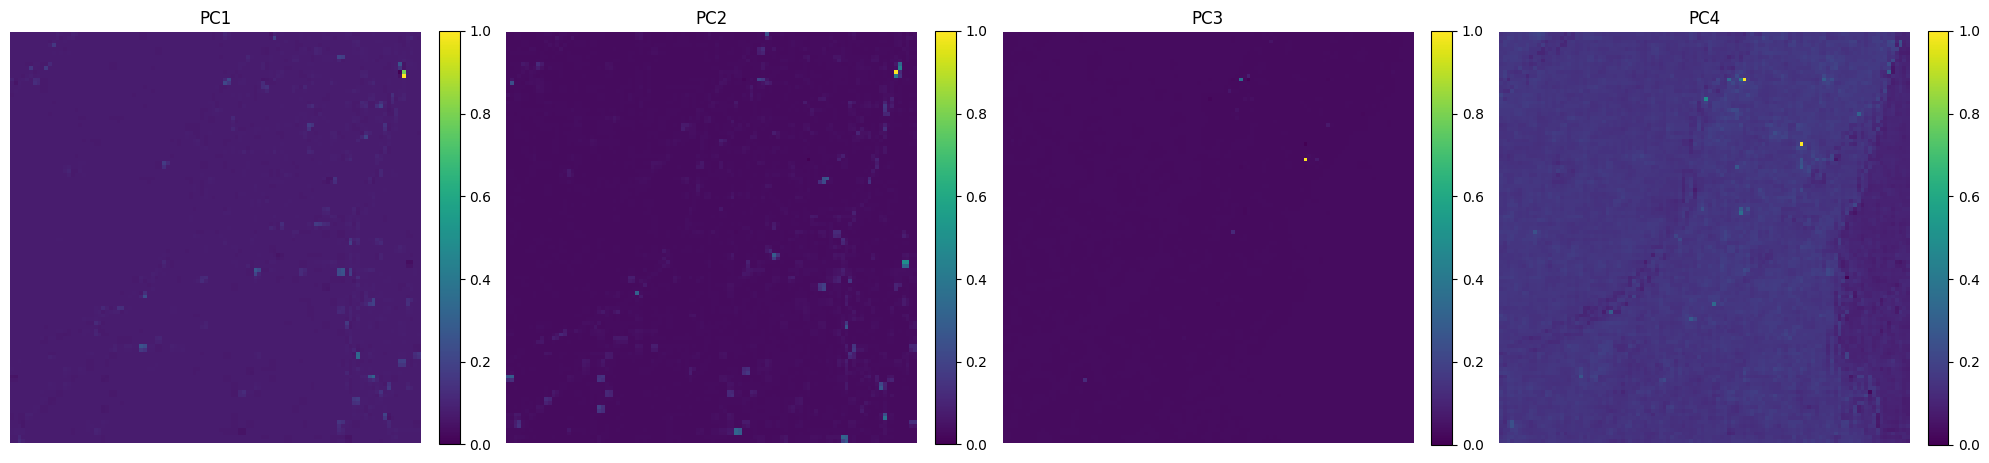

In [48]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

variables = ['PC1', 'PC2', 'PC3', 'PC4']

vmin, vmax = 0, 1  # fixed color scale limits

for ax, var in zip(axes, variables):
    im = ax.imshow(PCA_data[var], origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(var)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

#TODO train model over complete image size